# Seaborn tests

## Imports

In [22]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import warnings

from string import ascii_letters

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
dbi = qs.interfaces.DbIndicatorsInterface(username="rsueppel", host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                          password="l3oT7^WerjY#O!9EGqvL", database="qs_jpm_point_time")
cids_m = ['AUD', 'CAD', 'THB', 'ZAR']
cats_m = ['CABUSDBN', 'NFDIUSDBN']
df = dbi.get_series_values(category=cats_m, cross_section=cids_m, frequency="m")  # import grade 1 vintages

cids_d = ['AUD', 'BRL', 'CAD', 'EUR', 'GBP', 'KRW', 'INR', 'JPY', 'MXN', 'NZD', 'TRY', 'ZAR']
cats_d = ['FXXRUSD', 'FXCRYUSD']
dfd = dbi.get_series_values(category=cats_d, cross_section=cids_d, frequency="d")  # daily non-vintage data

In [4]:
dfd['ticker'] = dfd[['cross_section', 'category_code', 'adjustment']].agg('_'.join, axis=1)
dfd.ticker.unique()
print(dfd.ticker.unique())
dfd.info()

['CAD_FXCRYUSD_NSA' 'CAD_FXXRUSD_NSA' 'GBP_FXCRYUSD_NSA' 'GBP_FXXRUSD_NSA'
 'EUR_FXCRYUSD_NSA' 'EUR_FXXRUSD_NSA' 'NZD_FXCRYUSD_NSA' 'NZD_FXXRUSD_NSA'
 'AUD_FXCRYUSD_NSA' 'AUD_FXXRUSD_NSA' 'JPY_FXCRYUSD_NSA' 'JPY_FXXRUSD_NSA'
 'TRY_FXCRYUSD_NSA' 'TRY_FXXRUSD_NSA' 'ZAR_FXCRYUSD_NSA' 'ZAR_FXXRUSD_NSA'
 'BRL_FXCRYUSD_NSA' 'BRL_FXXRUSD_NSA' 'MXN_FXCRYUSD_NSA' 'MXN_FXXRUSD_NSA'
 'INR_FXCRYUSD_NSA' 'INR_FXXRUSD_NSA' 'KRW_FXCRYUSD_NSA' 'KRW_FXXRUSD_NSA']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159361 entries, 0 to 159360
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cross_section     159361 non-null  object 
 1   category_code     159361 non-null  object 
 2   adjustment        159361 non-null  object 
 3   release_date      159361 non-null  object 
 4   observation_date  159361 non-null  object 
 5   value             159361 non-null  float64
 6   ticker            159361 non-null  object 
dtypes:

## Check data 

Visualize data availability

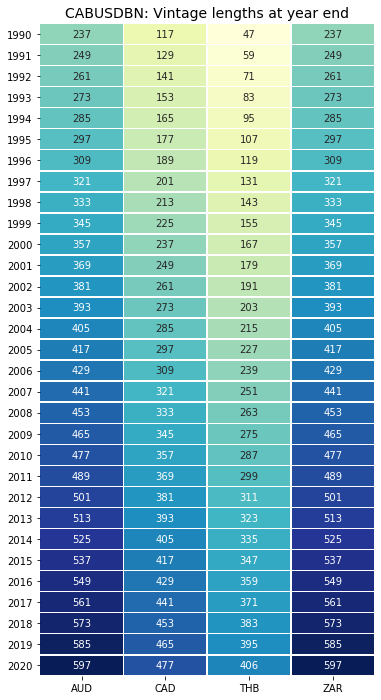

In [62]:
cat = 'CABUSDBN'
dfx = df[df['category_code']==cat]
xids = np.sort(dfx['cross_section'].unique())
dfx.loc[:, 'year'] = pd.DatetimeIndex(dfx.loc[:,'release_date']).year
dfx = dfx[dfx.year > 1989]

dfxx = pd.DataFrame(columns=dfx.columns)
for cid in xids:
    dfc = dfx.query('cross_section == @cid').reset_index(drop=True)
    releases = dfc[["year", "release_date"]].groupby("year")["release_date"].max().values.tolist()  # use panda series!
    dfcx = dfc[dfc['release_date'].isin(releases)]
    dfxx = dfxx.append(dfcx)

count_matrix = pd.crosstab(dfxx["year"], dfxx["cross_section"])  # per default crosstab counts rows
fig, ax = plt.subplots(figsize=(6, 12))
sns.heatmap(count_matrix, annot=True, fmt="d",
                cmap="YlGnBu", cbar=False, linewidths=.5)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(cat + ': Vintage lengths at year end', y = 1.1, fontsize=14)

plt.show()


Vintage observation counts across times and ticker.

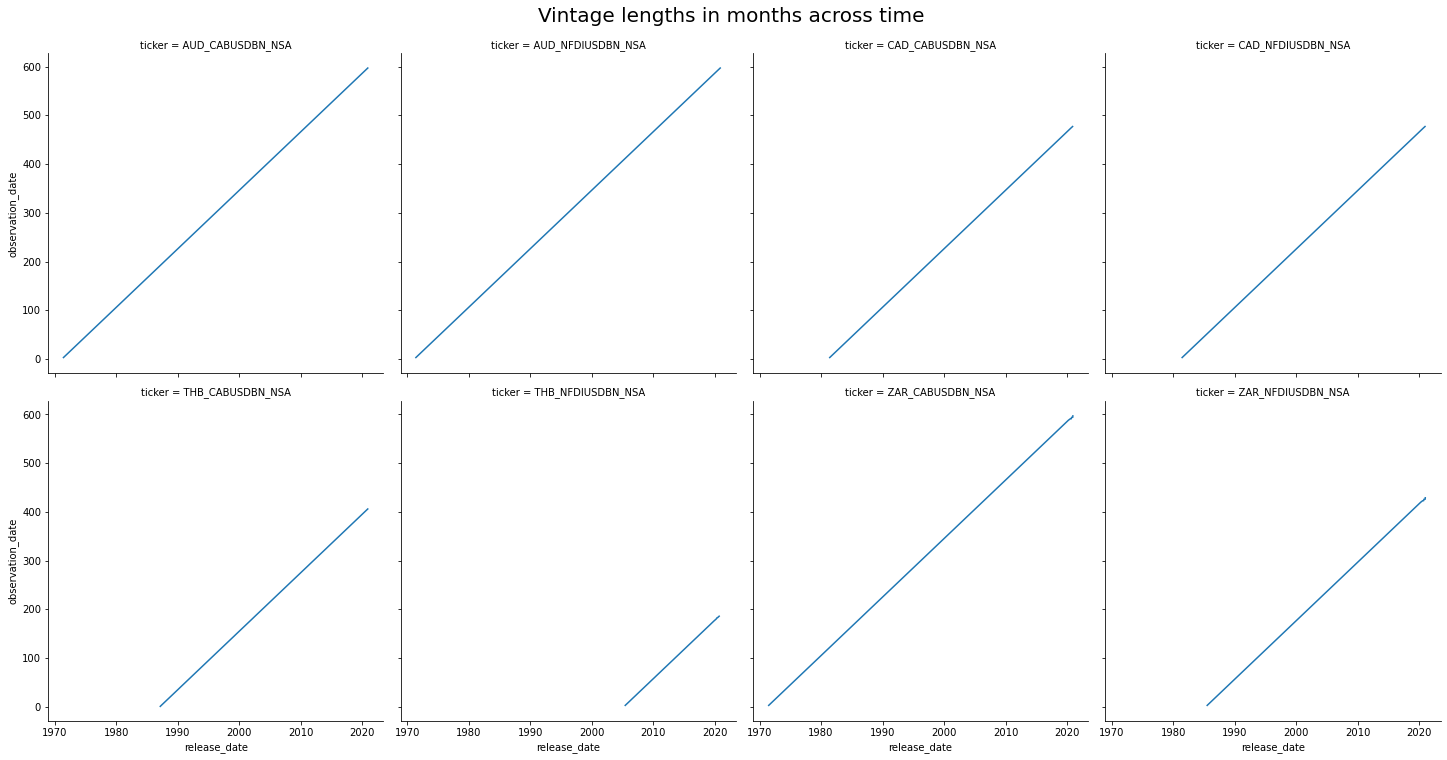

In [5]:
dfx = df.loc[:, ['ticker', 'release_date', 'observation_date']].groupby(['ticker', 'release_date']).agg('count')
dfx.reset_index(inplace=True)
g = sns.relplot(x='release_date', y = 'observation_date', data=dfx, kind='line', col='ticker', col_wrap=4)
g.fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20)
plt.show()

Visualize number of vintages per ticker by countplot.

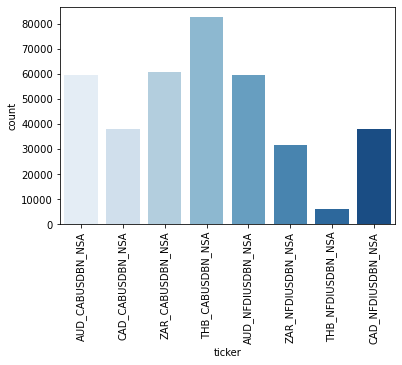

In [6]:
g = sns.countplot(data=df, x="ticker", palette='Blues')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

 Timelines of vintages for set of dates for specific ticker.

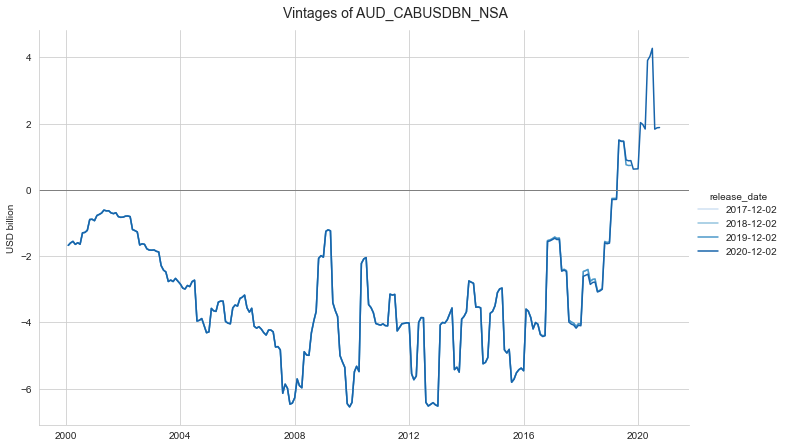

In [7]:
tick = 'AUD_CABUSDBN_NSA'
points_in_time = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
dfx = df[df['ticker']==tick]

sns.set_style('whitegrid')
releases = dfx.loc[:, 'release_date'].unique()
selected_releases = [None] * len(points_in_time)
for i in range(len(points_in_time)):
    release = releases[(releases <= pd.to_datetime(points_in_time[i]))].max()
    selected_releases[i] = release
dfxx = dfx[(dfx['release_date'].isin(selected_releases)) & (dfx['observation_date'] > pd.to_datetime('2000-01-01'))]
colors = sns.color_palette("Blues", len(points_in_time))
g = sns.relplot(
    data=dfxx,
    x="observation_date", y="value",
    hue="release_date",
    kind="line", palette=colors,
    height=6, aspect=1.6
)

g.axes[0][0].axhline(y=0, xmin=0, xmax=1, color='grey', linewidth=1)
g.fig.suptitle('Vintages of {}'.format(tick), y = 1.03, fontsize=14)
g.set_axis_labels("", "USD billion")
plt.show()

Barplots for comparable categories across sections.

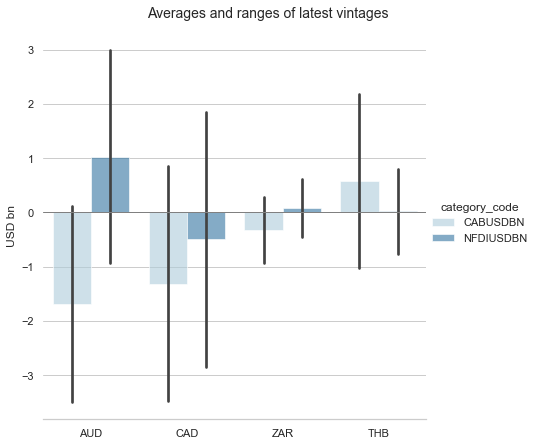

In [8]:
# Extract dataframe with last release_dates for each ticker only
indices = []
for tick in df.ticker.unique():
    dfx = df[df['ticker'] == tick]
    dfxx = dfx[dfx['release_date'] == dfx['release_date'].max()]
    indices = indices + dfxx.index.tolist()
dfg = df.iloc[indices, :]

# Barplot with sd vertical lines
sns.set(style="whitegrid")
g = sns.catplot(
    data=dfg, kind="bar",
    x="cross_section", y="value", hue="category_code",
    ci="sd", palette="Paired", alpha=.6, height=6
)
g.despine(left=True)
g.axes[0][0].axhline(y=0, xmin=0, xmax=1, color='grey', linewidth=1)
g.fig.suptitle('Averages and ranges of latest vintages', y = 1.03, fontsize=14)
g.set_axis_labels("", "USD bn")
plt.show()

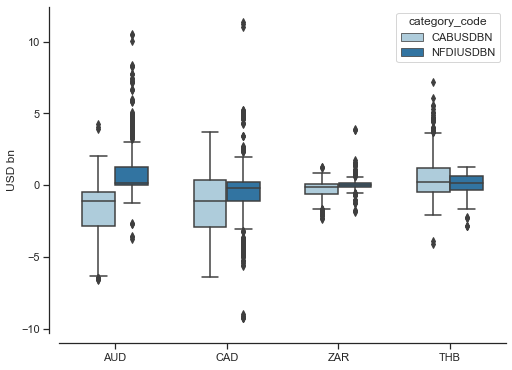

In [9]:
# Extract dataframe with last release_dates for each ticker only
indices = []
for tick in df.ticker.unique():
    dfx = df[df['ticker'] == tick]
    dfxx = dfx[dfx['release_date'] == dfx['release_date'].max()]
    indices = indices + dfxx.index.tolist()
dfg = df.iloc[indices, :]

# Nested boxplot
sns.set(rc={'figure.figsize':(8, 6)})  # set axis plot size
sns.set(style="ticks", palette="Paired")  
g = sns.boxplot(data=dfg,
            x="cross_section", y="value", hue="category_code",
            width=0.6)
sns.despine(offset=10, trim=False)
g.set(xlabel='', ylabel='USD bn')
plt.show()

Hexbin plot with marginal distributions of two series

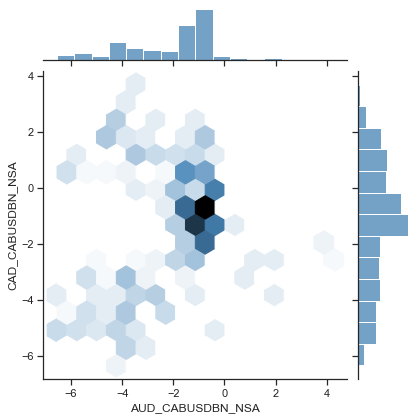

In [10]:
# Extract reduced dataframe with last release_dates for each ticker only
indices = []
for tick in df.ticker.unique():
    dfx = df[df['ticker'] == tick]
    dfxx = dfx[dfx['release_date'] == dfx['release_date'].max()]
    indices = indices + dfxx.index.tolist()
dfg = df.iloc[indices, :][['ticker', 'observation_date', 'value']].reset_index(drop=True)
dfg_w = dfg.pivot(index='observation_date', columns = 'ticker', values = 'value')

# Hexbin plot with marginal distributions of two series
sns.jointplot(data=dfg_w,kind="hex",
              x='AUD_CABUSDBN_NSA', y='CAD_CABUSDBN_NSA', 
              color="steelblue")
plt.show()

Conditional means of different categories across sections (alternative to boxplot)

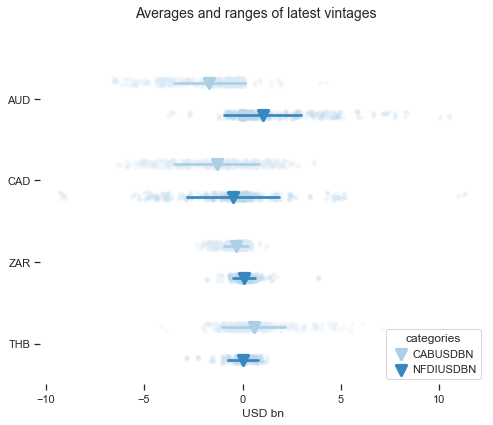

In [11]:
# Extract dataframe with last release_dates for each ticker only
indices = []
for tick in df.ticker.unique():
    dfx = df[df['ticker'] == tick]
    dfxx = dfx[dfx['release_date'] == dfx['release_date'].max()]
    indices = indices + dfxx.index.tolist()
dfg = df.iloc[indices, :]

f, ax = plt.subplots()
sns.set(style="ticks", palette = 'Blues')  
sns.despine(bottom=True, left=True)
sns.stripplot(data=dfg, # Show each observation with a scatterplot
              x="value", y="cross_section", hue="category_code",
              dodge=True, alpha=.2, zorder=1)
sns.pointplot(data=dfg,  # Show the conditional means
              x="value",  y="cross_section", hue="category_code",
              dodge=.4, join=False, palette='Blues',
              markers="v", scale=1.5, alpha=1, ci='sd')
f.suptitle('Averages and ranges of latest vintages', y = 1, fontsize=14)
ax.set(xlabel='USD bn', ylabel='')
handles, labels = ax.get_legend_handles_labels()  # refers to labels of strip- and pointplots
ax.legend(handles[2:], labels[2:], title="categories",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=1, frameon=True)
plt.show()

Plot cross-release date correlations for one series

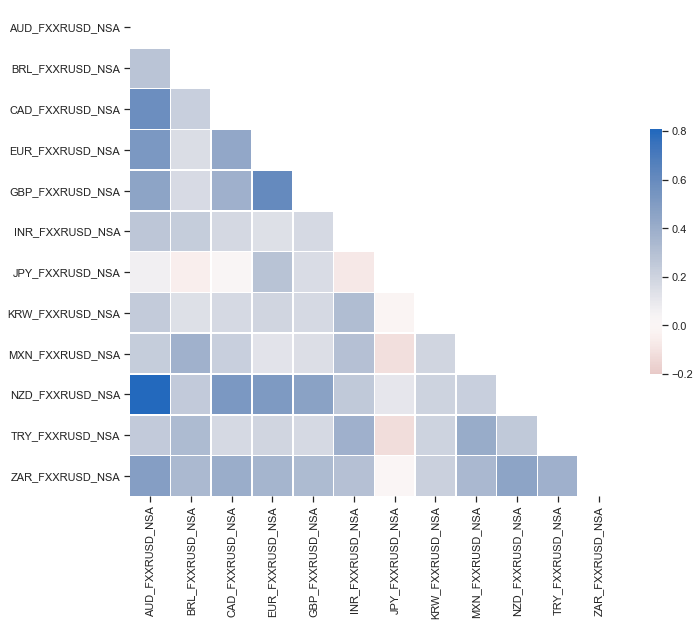

In [12]:
dfd_x = dfd[dfd['category_code'] == 'FXXRUSD']
dfd_xw = dfd_x.pivot(index='observation_date', columns='ticker', values = 'value')

sns.set(style="ticks")  
corr = dfd_xw.corr()  # compute correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))  # generate mask for upper triangle
f, ax = plt.subplots(figsize=(11, 9))  # set up figure

sns.heatmap(corr, mask=mask, cmap='vlag_r', vmin = -0.2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set(xlabel='', ylabel='')
plt.show()

Scatterplot for multiple cross sections (carry and returns, across sections and across decades)

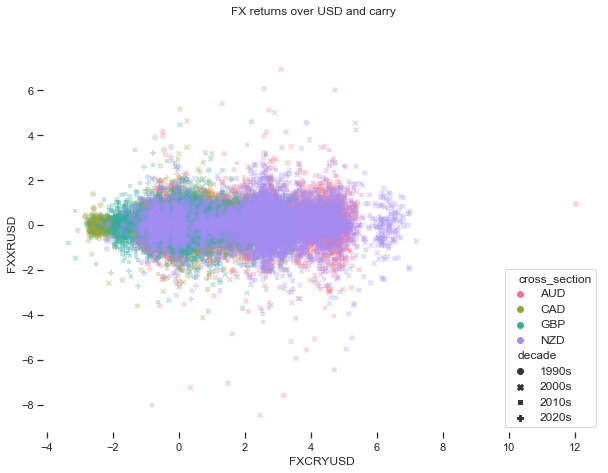

In [13]:
dfd_xw = dfd.loc[:, ['cross_section', 'category_code', 'observation_date', 'value']]
dfd_xw = dfd_xw[dfd_xw['cross_section'].isin(['AUD', 'CAD', 'GBP', 'NZD'])]
dfd_xw.set_index(['cross_section', 'category_code', 'observation_date'], inplace=True)
dfd_xw = dfd_xw.unstack(1).reset_index()
dfd_xw['decade'] = [str(n)+'s' for n in 10*(pd.DatetimeIndex(dfd_xw['observation_date']).year//10)]
dfd_xw.columns = ['cross_section', 'observation_date', 'FXCRYUSD', 'FXXRUSD', 'decade']
dfd_xw.tail()

f, ax = plt.subplots(figsize=(10, 7))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x='FXCRYUSD', y='FXXRUSD',
                style="decade", hue="cross_section",
                palette="husl",
                linewidth=0,
                alpha=0.3,
                data=dfd_xw, ax=ax)
f.suptitle('FX returns over USD and carry', y = 0.97, fontsize=12)
plt.show()


Two-dimensional histograms

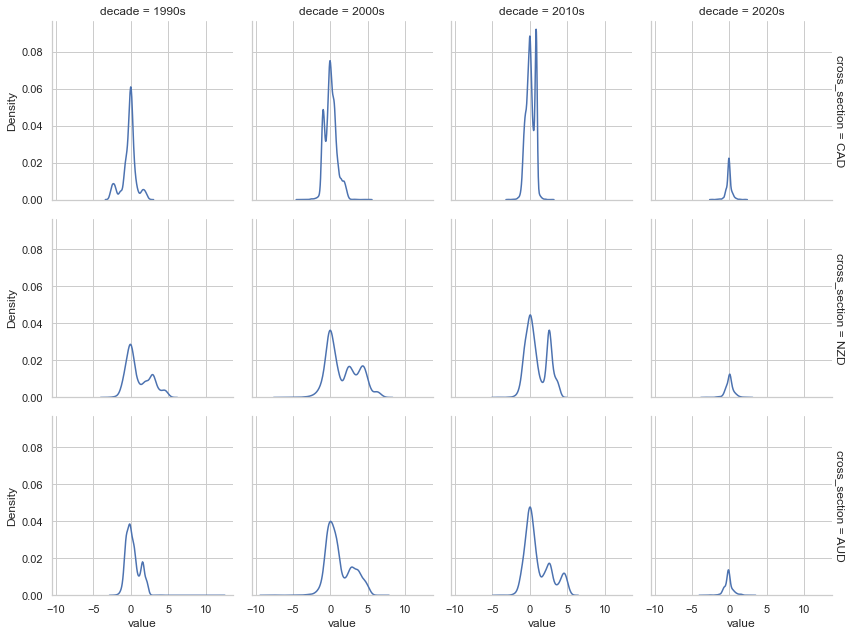

In [14]:
dfd = dfd[dfd['cross_section'].isin(['AUD', 'CAD', 'NZD'])]
dfd['decade'] = [str(n)+'s' for n in 10*(pd.DatetimeIndex(dfd['observation_date']).year//10)]


sns.set_theme(style="whitegrid")
sns.displot(
    data=dfd, x="value", kind='kde',
    col="decade", row="cross_section",
    height=3, facet_kws=dict(margin_titles=True),
)

plt.show()

## Datacamp code

Distribution with density estimate

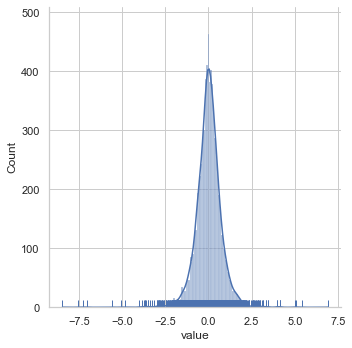

In [15]:
tick = 'AUD_FXXRUSD_NSA'
dfd_x = dfd[dfd['ticker'] == tick]
sns.displot(dfd_x['value'], kde=True, rug=True)
plt.show()

Facet of regression plots.

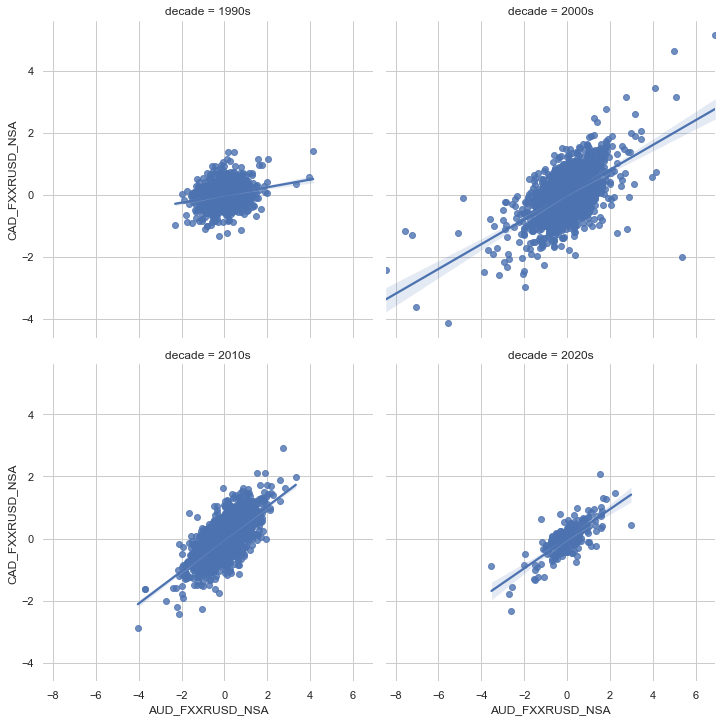

In [16]:
dfd_x = dfd[dfd['category_code'] == 'FXXRUSD']
dfd_xw = dfd_x.pivot(index='observation_date', columns='ticker', values = 'value')
dfd_xw['decade'] = [str(n)+'s' for n in 10*(pd.DatetimeIndex(dfd_xw.index).year//10)]

sns.set(style="whitegrid")
sns.lmplot(data=dfd_xw, x='AUD_FXXRUSD_NSA', y='CAD_FXXRUSD_NSA', x_ci = 'ci', col='decade', col_wrap=2)
sns.despine(left=True, bottom=True)
plt.show()